In [3]:
import pandas as pd
import numpy as np
import requests
import json
import time
import os
from html import unescape
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import (cross_val_score, GridSearchCV, train_test_split)
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('./Data/Post_Data.csv',index_col=0)

In [6]:
data = data.dropna()

In [7]:
X = data.content

In [8]:
y = data.is_class

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=123,stratify=y)

In [10]:
count_vectorizer = CountVectorizer(stop_words='english')

In [11]:
X_train_CV = count_vectorizer.fit_transform(X_train)
X_test_CV = count_vectorizer.transform(X_test)

In [12]:
X_train_CV_DF = pd.DataFrame(X_train_CV.todense(),columns=count_vectorizer.get_feature_names_out())

In [13]:
X_test_CV_DF = pd.DataFrame(X_test_CV.todense(),columns=count_vectorizer.get_feature_names_out())

### Other Analysis Charts

In [14]:
eda_df = X_train_CV_DF.copy()

In [15]:
eda_df['target'] = y_train

In [16]:
eda_df.sum().sort_values(ascending=False)[:20]

num         4425.0
target      2938.0
space        827.0
study        491.0
moon         463.0
new          441.0
nasa         375.0
earth        340.0
like         292.0
years        290.0
artemis      285.0
time         257.0
people       240.0
just         236.0
emoji        215.0
black        200.0
launch       195.0
universe     186.0
https        183.0
mars         182.0
dtype: float64

In [17]:
space_stats = eda_df[eda_df['target']==1].sum().sort_values(ascending=False)[1:11] / eda_df[eda_df['target']==1].sum().sum()
space_stats_in = space_stats.index

<AxesSubplot: title={'center': 'R/Space Word Usage'}, ylabel='% across R/Space Posts'>

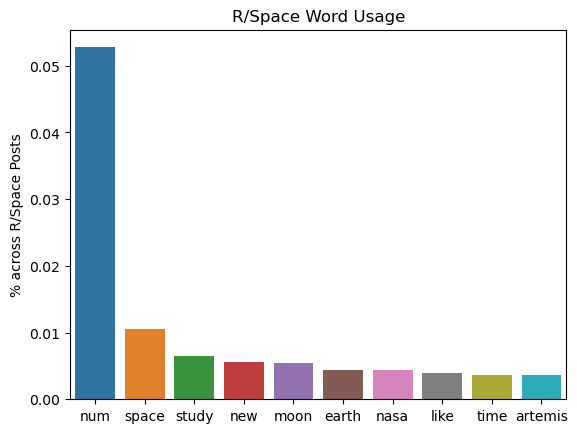

In [21]:
plt.title('R/Space Word Usage')
plt.ylabel('% across R/Space Posts')
sns.barplot(x=space_stats_in,y=space_stats)

In [19]:
science_stats=eda_df[eda_df['target']==0].sum().sort_values(ascending=False)[:10] / eda_df[eda_df['target']==0].sum().sum()

<AxesSubplot: title={'center': 'R/Science Word Usage'}, ylabel='% across R/Science Posts'>

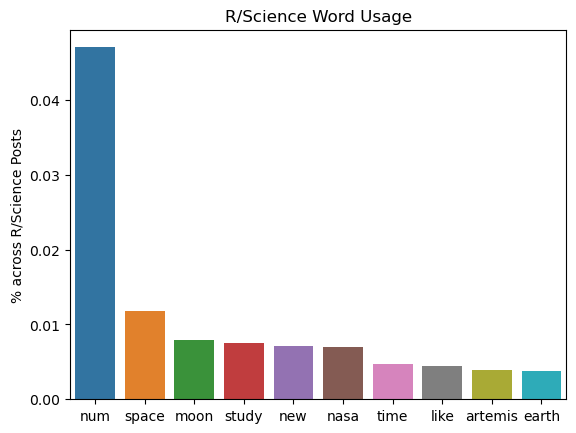

In [22]:
plt.title('R/Science Word Usage')
plt.ylabel('% across R/Science Posts')
sns.barplot(x = science_stats.index,y=science_stats)

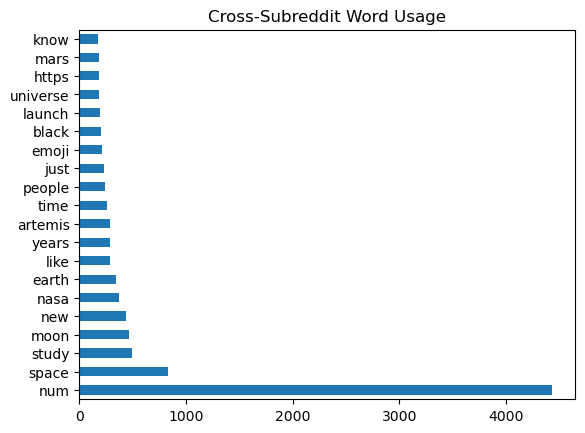

In [43]:
plt.title('Cross-Subreddit Word Usage')
X_train_CV_DF.sum().sort_values(ascending=False).head(20).plot(kind='barh');

### Model Production

- Ultimately I produced 3 models, each of which I have iteratively tailored my hyperparameters. The logistic regression model ended up with the best r2

#### Logistic Regression

In [19]:
log_reg_pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=1e4,solver='saga',random_state=123,n_jobs = -1))
])

log_reg_params_alpha = {
    'lr__C': [.1, 1, 10],
    'lr__penalty': ['l1', 'l2'],
    'tf__max_features': [500,1000,2000],
    'tf__min_df': [2,4,8],
    'tf__ngram_range':[(1,1), (1,2), (2,2)],
    'tf__max_df': [0.25, 0.5, 0.8]
}

log_reg_GS = GridSearchCV(estimator = log_reg_pipeline, param_grid = log_reg_params_alpha, n_jobs = -1)

log_reg_GS.fit(X_train, y_train)

log_reg_GS.best_params_

{'lr__C': 1,
 'lr__penalty': 'l2',
 'tf__max_df': 0.25,
 'tf__max_features': 2000,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 1)}

In [20]:
params_beta = {
    'lr__C': [1, 2, 5, 10],
    'lr__penalty': ['l2'],
    'tf__max_features': [1500,2000,2500],
    'tf__min_df': [3,4,5],
    'tf__ngram_range':[(1,1)],
    'tf__max_df': [0.15,0.25,0.35]
}

In [21]:
GS_beta = GridSearchCV(estimator = log_reg_pipeline, param_grid = params_beta, n_jobs = -1)

GS_beta.fit(X_train, y_train)

beta_params = GS_beta.best_params_
log_reg_pipeline.set_params(**beta_params)
log_reg_pipeline.fit(X_train,y_train)

Pipeline(steps=[('tf',
                 TfidfVectorizer(max_df=0.25, max_features=2500, min_df=3)),
                ('lr',
                 LogisticRegression(C=2, max_iter=10000.0, n_jobs=-1,
                                    random_state=123, solver='saga'))])

In [22]:
log_reg_pipeline.score(X_test,y_test)

0.8771163298743856

### Model 2: K-Nearest-Neighbors

In [44]:
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_param_grid = {
    'knn__n_neighbors': [5, 10, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}
grid_search = GridSearchCV(knn_pipe, knn_param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_CV_DF, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [45]:
knn_pipe.set_params(**best_params)
knn_pipe.fit(X_train_CV_DF, y_train)
knn_pipe.score(X_test_CV_DF,y_test)

0.5510649918077554

### Model 3: Random Forest

In [47]:
forest_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('rf', RandomForestClassifier())
])

forest_parameters = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [1, 2, 3],
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

forest_grid_search = GridSearchCV(forest_pipeline, forest_parameters, cv=5, n_jobs=-1, verbose=1)
forest_grid_search.fit(X_train, y_train)

forest_pipeline.set_params(**forest_grid_search.best_params_)
forest_pipeline.fit(X_train,y_train)
forest_pipeline.score(X_test,y_test)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


0.8711086837793556

In [48]:
beta_forest_pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('rf', RandomForestClassifier())
])

beta_forest_parameters = {
    'tf__max_features': [500,1000,2000],
    'tf__min_df': [2,4,8],
    'tf__ngram_range':[(1,1), (1,2), (2,2)],
    'tf__max_df': [0.25, 0.5, 0.8],
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

beta_forest_grid_search = GridSearchCV(beta_forest_pipeline, beta_forest_parameters, cv=5, n_jobs=-1, verbose=1)
beta_forest_grid_search.fit(X_train, y_train)

beta_forest_pipeline.set_params(**beta_forest_grid_search.best_params_)
beta_forest_pipeline.fit(X_train,y_train)
beta_forest_pipeline.score(X_test,y_test)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


0.8552703440742764

In [ ]:
y_hat_forest_beta = beta_forest_pipeline.predict(X_test)